<a href="https://colab.research.google.com/github/zuzannazak/PhD2022Bialowieza/blob/main/%F0%9F%92%96projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Study on orthodox population in Białowieża 1878-2020***




**Authors:**

Wiktoria Rakowska

Monika Wesołowska

Zuzanna Żak


**Data:**
*   Aggregated in https://github.com/zuzannazak/PhD2022Bialowieza/blob/main/bialowieza_aggregated.xls?raw=true :
  *   Chrzty, śluby i zgony w parafii prawosłwanej św. Mikołaja Cudotwórcy w Białowieży https://github.com/pbiecek/SmarterPoland_blog/tree/master/dane/Bialowieza/
  *   Population data for Białowieża, rural gmina, from Bank Danych Lokalnych
  *   Population data for Poland https://stat.gov.pl/obszary-tematyczne/ludnosc/ludnosc/struktura-ludnosci,16,1.html 
  *   Religious practices in Poland https://cbos.pl/SPISKOM.POL/2020/K_063_20.PDF 

# ***introduction***



*   Białowieża i trochę o historii miasta
*   Fajne dane urywajace się na 2012 (tutaj można wpleść też niektóre wykresy z sekcji visualization (zmienić kolejność bloków strzałkami i wrzucić je pomiędzy bloki tekstu) + ze jest dziura na poczatku XX wieku widac na jednym z wykresów
*   Projekt - dokończenie tych danych, czyli predykcja dalszych małżeństw, chrztów i zgonów
*   Dodatkowe dane: dane na temat małżeństw, urodzeń i zgonów z gminy, populacja polski, saldo migracji
*   consideration: religijność w polsce, przewidujemy rejestr kościelny (cerkiewny) więc w przypadku spadku religijności można spodziewać się spadek tych wartości w rejestrze, nawet jeśli dane cywilne tego nie pokazują



# ***package import***

In [ ]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sns.set_palette("Set2")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# ***data download***

Original data from Białowieża orthodox church records contains the number of baptisms, marriages and deaths in a particular year.

In [ ]:
#original Białowieża data
url_data = (r'https://raw.github.com/pbiecek/SmarterPoland_blog/master/dane/Bialowieza/bialowieza.xls')
df = pd.read_excel(url_data)

df.head()

,rok,chrzest,slub,zgon
0,1878,62.0,2.0,44.0
1,1879,77.0,14.0,38.0
2,1880,79.0,14.0,60.0
3,1881,NaN,NaN,NaN
4,1882,86.0,17.0,52.0


Additional data was added from Główny Urząd Statystyczny. Bank Danych Lokalnych about Białowieża county (the original data is for Białowieża village orthodox church only) was used to provide the information about marriages in the county (GUS - Małżeństwa zawarte w gminie), net migrations in the county (GUS - saldo migracji ogółem), population of Białowieża county (GUS - Ludność w gminie), births in the county (GUS - urodzenia żywe w gminie) and deaths in the county (GUS - zgony w gminie). Other variables were taken from general databases of GUS and calculated for the whole Poland.

In [ ]:
#aggregated data
url_data = (r'https://github.com/zuzannazak/PhD2022Bialowieza/blob/main/bialowieza_aggregated.xls?raw=true')
df_aggregateddata = pd.read_excel(url_data)

df_aggregateddata.tail(10)

,rok,chrzest,slub,zgon,GUS - Małżeństwa zawarte w gminie,GUS - saldo migracji ogółem,GUS - Ludność w gminie,GUS - Ludność w Polsce stan w dniu 31.XII (tys.),GUS - urodzenia żywe w gminie,GUS - zgony w gminie,CBOS - % Wierzący i praktykujący regularnie,CBOS - % Wierzący i praktykujący nieregularnie,CBOS - % Niewierzący i niepraktykujący
138,2016,NaN,NaN,NaN,11.0,-3.0,2205.0,38433.0,14.0,47.0,50.0,36.0,5.0
139,2017,NaN,NaN,NaN,5.0,83.0,2253.0,38434.0,10.0,45.0,49.0,37.0,5.0
140,2018,NaN,NaN,NaN,10.0,12.0,2199.0,38411.0,12.0,44.0,50.0,36.0,6.0
141,2019,NaN,NaN,NaN,13.0,-12.0,2191.0,38383.0,18.0,47.0,47.0,36.0,6.0
142,2020,NaN,NaN,NaN,7.0,-14.0,2130.0,NaN,8.0,44.0,47.0,37.0,7.0
143,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Orthodox church records stop at 2012. Data on Polish population number is available from 1950, but other additional variables are generally available from 1995 to 2020. 

The aim of the project would be to predict the values of baptisms, marriages and deaths recorded by the orthodox population in Białowieża.

In [ ]:
df_aggregateddata.drop(df_aggregateddata.tail(5).index,inplace=True)
df_aggregateddata

,rok,chrzest,slub,zgon,GUS - Małżeństwa zawarte w gminie,GUS - saldo migracji ogółem,GUS - Ludność w gminie,GUS - Ludność w Polsce stan w dniu 31.XII (tys.),GUS - urodzenia żywe w gminie,GUS - zgony w gminie,CBOS - % Wierzący i praktykujący regularnie,CBOS - % Wierzący i praktykujący nieregularnie,CBOS - % Niewierzący i niepraktykujący
0,1878,62.0,2.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1879,77.0,14.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1880,79.0,14.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1882,86.0,17.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,2016,NaN,NaN,NaN,11.0,-3.0,2205.0,38433.0,14.0,47.0,50.0,36.0,5.0
139,2017,NaN,NaN,NaN,5.0,83.0,2253.0,38434.0,10.0,45.0,49.0,37.0,5.0
140,2018,NaN,NaN,NaN,10.0,12.0,2199.0,38411.0,12.0,44.0,50.0,36.0,6.0
141,2019,NaN,NaN,NaN,13.0,-12.0,2191.0,38383.0,18.0,47.0,47.0,36.0,6.0


#***data visualisation*** 

On the chart below we can see the changes to number of baptisms, weddings and deaths recorded by the orthodox church i Białowieża through the years. Major world events influencing the changes were described on the chart.

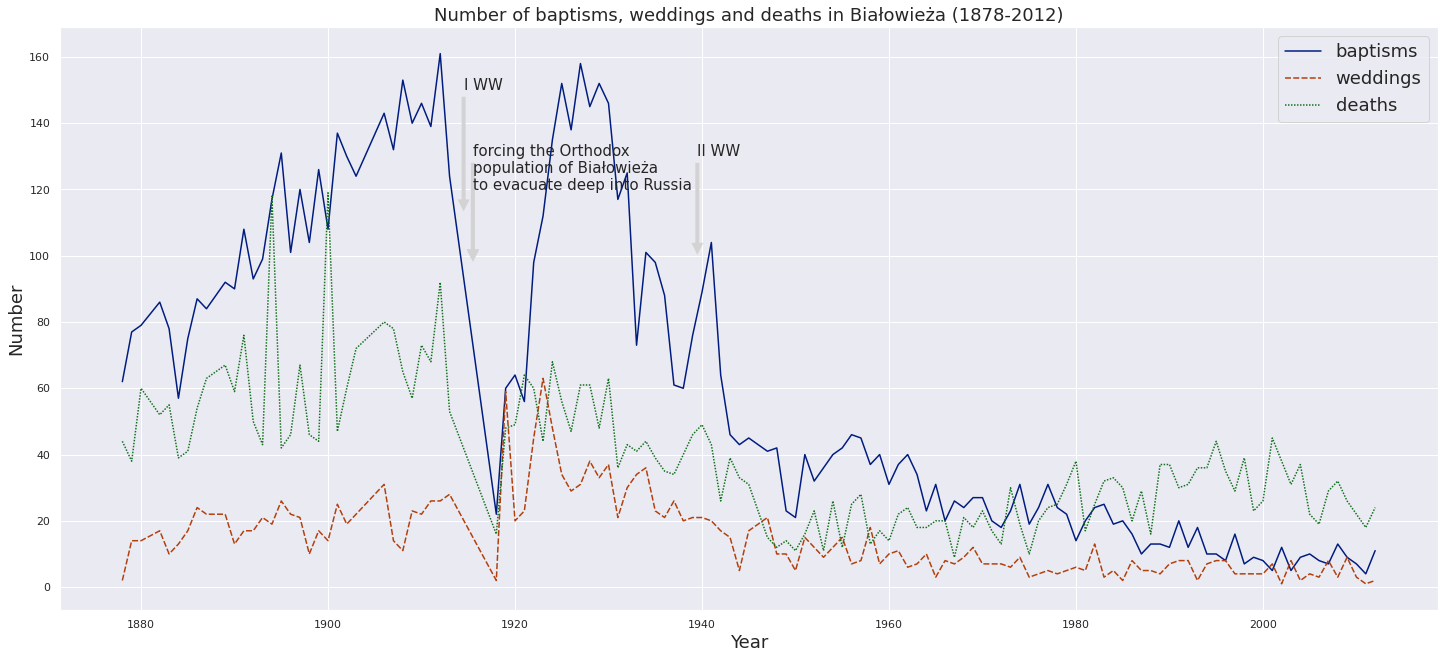

In [ ]:
url_data = (r'https://github.com/zuzannazak/PhD2022Bialowieza/blob/main/bialowieza_visualisation.xlsx?raw=true')
DF = pd.read_excel(url_data)
plt.figure(figsize=(22,10))
plt.title("Number of baptisms, weddings and deaths in Białowieża (1878-2012)", fontsize=18)
g=sns.lineplot(x=DF["rok"], y=DF["liczba odnotowanych"], hue=DF["zdarzenie"], style=DF["zdarzenie"], palette='dark', legend=True, ci=True)

plt.annotate('I WW', xy=(1914.5, 113), xytext=(1914.5, 150), fontsize=15, arrowprops=dict(facecolor='lightgrey', shrink=0.01, linewidth=0))
plt.annotate('II WW', xy=(1939.5, 100), xytext=(1939.5, 130), fontsize=15, arrowprops=dict(facecolor='lightgrey', shrink=0.01, linewidth=0))
plt.annotate('forcing the Orthodox', xy=(1915.5, 98), xytext=(1915.5, 130), fontsize=15, arrowprops=dict(facecolor='lightgrey', shrink=0.01, linewidth=0))
plt.annotate('population of Białowieża', xy=(1915.5, 98), xytext=(1915.5, 125), fontsize=15, arrowprops=dict(facecolor='lightgrey', shrink=0.01, linewidth=0))
plt.annotate('to evacuate deep into Russia', xy=(1915.5, 98), xytext=(1915.5, 120), fontsize=15, arrowprops=dict(facecolor='lightgrey', shrink=0.01, linewidth=0))
plt.ylabel('Number', fontsize=18)
plt.xlabel('Year',fontsize=18 )
plt.legend(fontsize=18 )

sns.set_style("whitegrid")
plt.style.use('fivethirtyeight')
sns.set_theme()

Some of the information in the data is missing and it is represented on the chart below. As one can see, in late 1910s the village population needed to go into hiding, which caused the lack of records for that time.

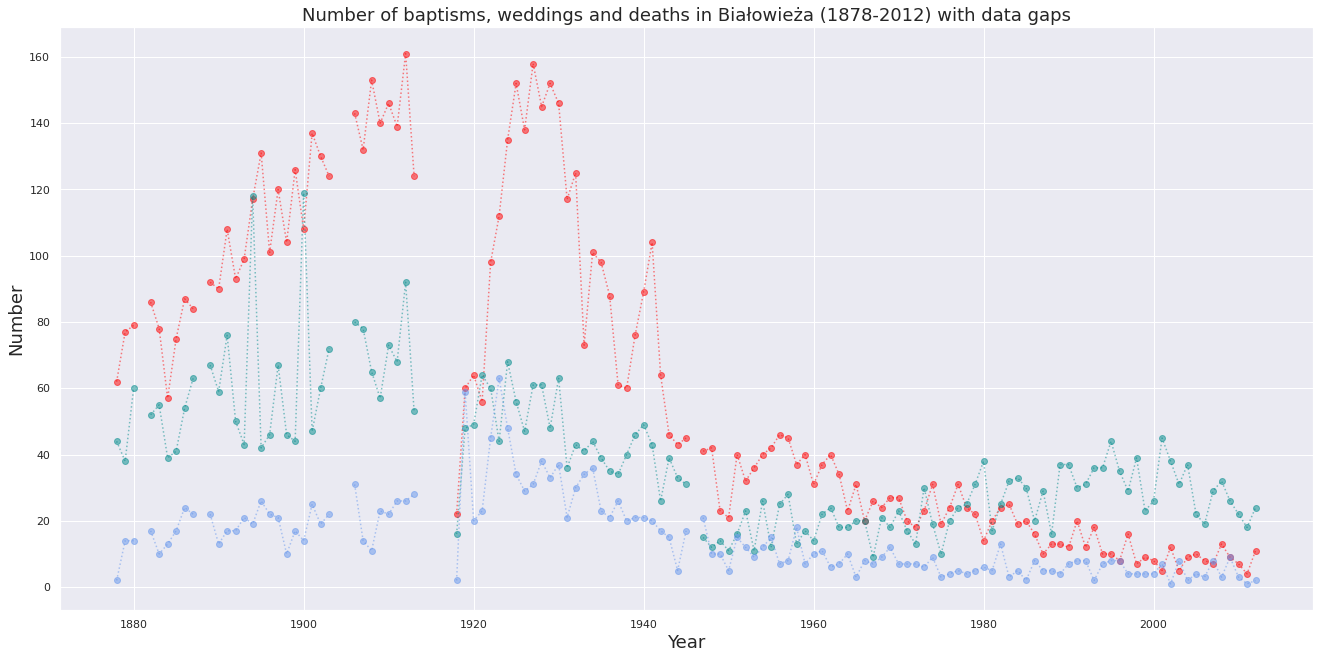

In [ ]:
Data1 = DF[DF['zdarzenie'] == 'baptisms']
Data2 = DF[DF['zdarzenie'] == 'deaths']
Data3 = DF[DF['zdarzenie'] == 'weddings']

cols_plot = [ 'liczba odnotowanych', "rok"]
fig, ax = plt.subplots()
ax.plot(Data1["rok"], Data1["liczba odnotowanych"],marker='o', color="red",alpha=0.5, linestyle='dotted')
ax.plot(Data2["rok"], Data2["liczba odnotowanych"],marker='o', color="darkcyan",alpha=0.5, linestyle='dotted')
ax.plot(Data3["rok"], Data3["liczba odnotowanych"],marker='o', color="cornflowerblue",alpha=0.5, linestyle='dotted')
plt.title("Number of baptisms, weddings and deaths in Białowieża (1878-2012) with data gaps", fontsize=18)
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('Number', fontsize=18)
fig.set_size_inches(20, 10)

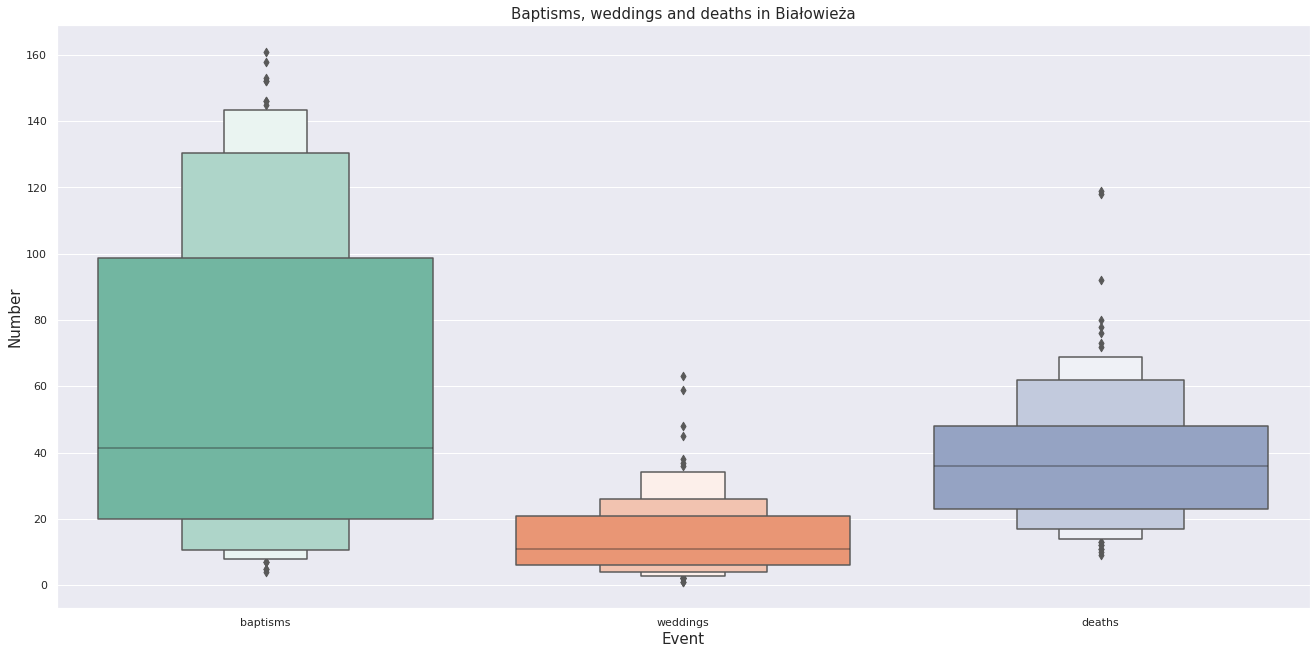

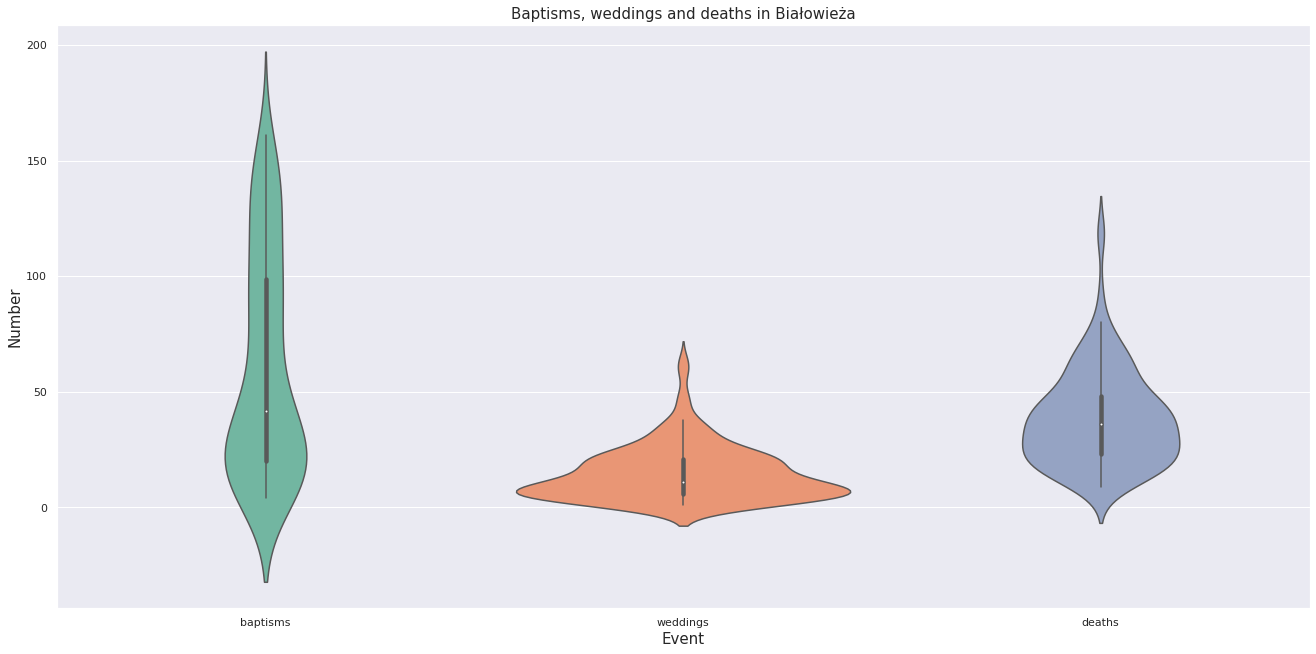

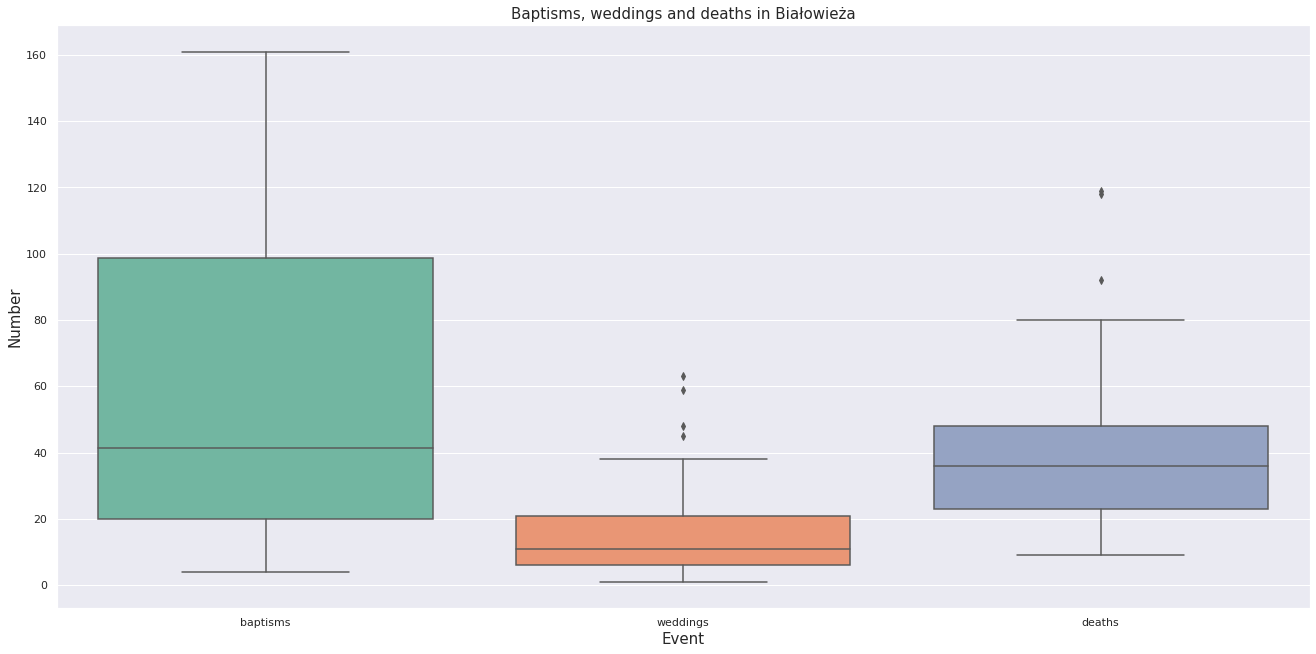

In [ ]:
plt.figure(figsize=(20, 10))
sns.boxenplot(x=DF["zdarzenie"], y=DF["liczba odnotowanych"], palette="Set2")
plt.title("Baptisms, weddings and deaths in Białowieża",fontsize=15)
plt.ylabel('Number', fontsize=15)
plt.xlabel('Event',fontsize=15 )
plt.show()

plt.figure(figsize=(20, 10))
sns.violinplot(x=DF["zdarzenie"], y=DF["liczba odnotowanych"], palette="Set2")
plt.title("Baptisms, weddings and deaths in Białowieża",fontsize=15)
plt.ylabel('Number', fontsize=15)
plt.xlabel('Event',fontsize=15 )
plt.show()

plt.figure(figsize=(20, 10))
sns.boxplot(x=DF["zdarzenie"], y=DF["liczba odnotowanych"], palette="Set2")
plt.title("Baptisms, weddings and deaths in Białowieża",fontsize=15)
plt.ylabel('Number', fontsize=15)
plt.xlabel('Event',fontsize=15 )
plt.show()

# ***analysis***

##***dependency analysis***

Text(0.5, 0.98, 'dependency analysis')

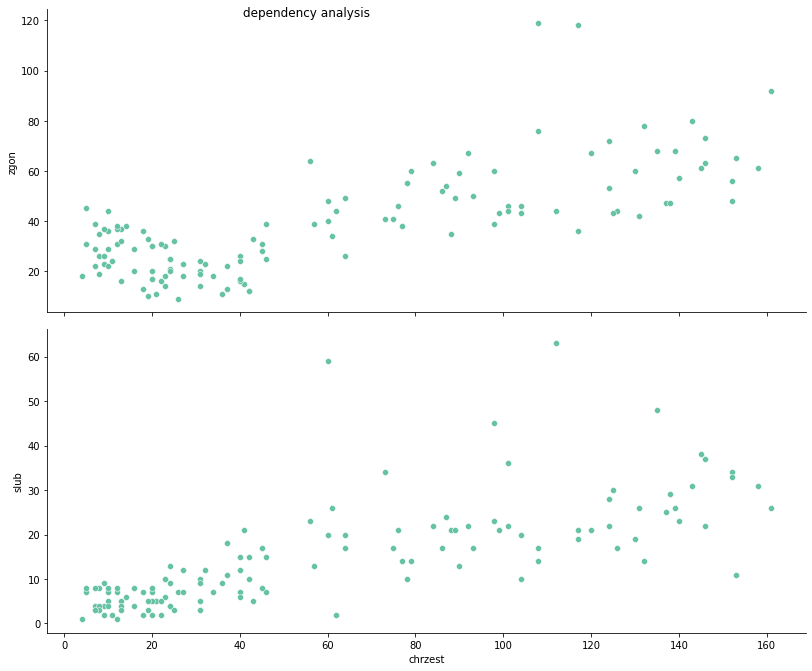

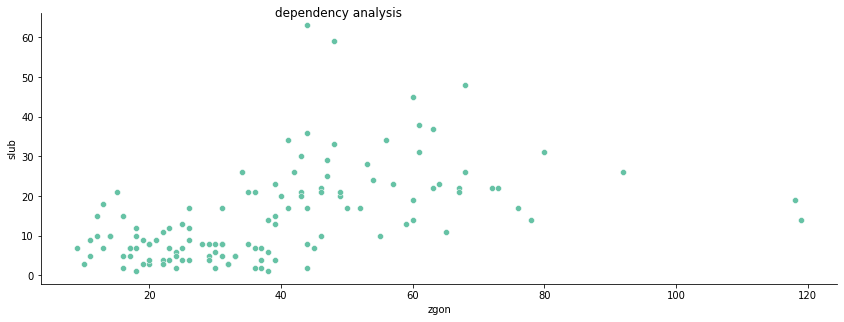

In [ ]:
g=sns.pairplot(df, x_vars=["chrzest"], y_vars=["zgon", "slub"])
g.fig.suptitle("dependency analysis")
g.fig.set_size_inches(15,10)
g=sns.pairplot(df, x_vars=["zgon"], y_vars=["slub"])
g.fig.set_size_inches(15,5)
g.fig.suptitle("dependency analysis")

## **correlation**

In [ ]:
#correlation
korel = df_aggregateddata.corr()
df_aggregateddata.corr()

,rok,chrzest,slub,zgon,GUS - Małżeństwa zawarte w gminie,GUS - saldo migracji ogółem,GUS - Ludność w gminie,GUS - Ludność w Polsce stan w dniu 31.XII (tys.),GUS - urodzenia żywe w gminie,GUS - zgony w gminie,CBOS - % Wierzący i praktykujący regularnie,CBOS - % Wierzący i praktykujący nieregularnie,CBOS - % Niewierzący i niepraktykujący
rok,1.000000,-0.800298,-0.571327,-0.630441,-0.165181,0.105424,-0.978255,0.917230,-0.609959,-0.530095,-0.930674,0.897718,0.923629
chrzest,-0.800298,1.000000,0.734576,0.740269,0.326517,0.019477,0.239191,-0.861808,0.380729,0.167780,0.131010,-0.129532,-0.123442
slub,-0.571327,0.734576,1.000000,0.506627,0.379970,-0.233923,0.387479,-0.585242,0.149044,0.292203,0.149049,-0.130163,-0.348871
zgon,-0.630441,0.740269,0.506627,1.000000,-0.127775,0.072397,0.595813,0.590339,0.125313,0.830574,0.251019,-0.398130,-0.564912
GUS - Małżeństwa zawarte w gminie,-0.165181,0.326517,0.379970,-0.127775,1.000000,-0.409802,0.178516,-0.332330,0.452830,-0.081880,0.248761,-0.197831,-0.248697
GUS - saldo migracji ogółem,0.105424,0.019477,-0.233923,0.072397,-0.409802,1.000000,-0.096963,0.170489,-0.253708,0.022278,-0.104969,0.188214,0.026213
GUS - Ludność w gminie,-0.978255,0.239191,0.387479,0.595813,0.178516,-0.096963,1.000000,-0.665547,0.612382,0.565144,0.930387,-0.921283,-0.925625
GUS - Ludność w Polsce stan w dniu 31.XII (tys.),0.917230,-0.861808,-0.585242,0.590339,-0.332330,0.170489,-0.665547,1.000000,-0.272938,-0.377598,-0.749222,0.775462,0.762666
GUS - urodzenia żywe w gminie,-0.609959,0.380729,0.149044,0.125313,0.452830,-0.253708,0.612382,-0.272938,1.000000,0.359363,0.470572,-0.434410,-0.429872
GUS - zgony w gminie,-0.530095,0.167780,0.292203,0.830574,-0.081880,0.022278,0.565144,-0.377598,0.359363,1.000000,0.264394,-0.359419,-0.388005


## **filling in data gaps**
There is a large amount of data gaps in the dataset. This is mostly due to the fact that variables from other sources than orthodox church records weren't available as early as 1878.

In [ ]:
#data gaps
df_aggregateddata.isnull().sum()


rok                                                    0
chrzest                                               17
slub                                                  17
zgon                                                  17
GUS - Małżeństwa zawarte w gminie                    117
GUS - saldo migracji ogółem                          117
GUS - Ludność w gminie                               117
GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)     73
GUS - urodzenia żywe w gminie                        117
GUS - zgony w gminie                                 117
CBOS - % Wierzący i praktykujący regularnie          119
CBOS - % Wierzący i praktykujący nieregularnie       119
CBOS - % Niewierzący i niepraktykujący               119
dtype: int64

In [ ]:
CORREL = df_aggregateddata.corr()
CORREL['chrzest'].to_frame().sort_values('chrzest')
CORREL = df_aggregateddata.corr()
CORREL['slub'].to_frame().sort_values('slub')
CORREL = df_aggregateddata.corr()
CORREL['zgon'].to_frame().sort_values('zgon')
CORREL = df_aggregateddata.corr()
CORREL['GUS - Małżeństwa zawarte w gminie'].to_frame().sort_values('GUS - Małżeństwa zawarte w gminie')
CORREL = df_aggregateddata.corr()
CORREL['GUS - saldo migracji ogółem'].to_frame().sort_values('GUS - saldo migracji ogółem')
CORREL = df_aggregateddata.corr()
CORREL['GUS - Ludność w gminie'].to_frame().sort_values('GUS - Ludność w gminie')
CORREL = df_aggregateddata.corr()
CORREL['GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)'].to_frame().sort_values('GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)')
CORREL = df_aggregateddata.corr()
CORREL['GUS - urodzenia żywe w gminie'].to_frame().sort_values('GUS - urodzenia żywe w gminie')
CORREL = df_aggregateddata.corr()
CORREL['GUS - zgony w gminie'].to_frame().sort_values('GUS - zgony w gminie')
CORREL = df_aggregateddata.corr()
CORREL['CBOS - % Wierzący i praktykujący regularnie'].to_frame().sort_values('CBOS - % Wierzący i praktykujący regularnie')
CORREL = df_aggregateddata.corr()
CORREL['CBOS - % Wierzący i praktykujący nieregularnie'].to_frame().sort_values('CBOS - % Wierzący i praktykujący nieregularnie')
CORREL = df_aggregateddata.corr()
CORREL['CBOS - % Niewierzący i niepraktykujący'].to_frame().sort_values('CBOS - % Niewierzący i niepraktykujący')

,CBOS - % Niewierzący i niepraktykujący
CBOS - % Wierzący i praktykujący regularnie,-0.940103
GUS - Ludność w gminie,-0.925625
zgon,-0.564912
GUS - urodzenia żywe w gminie,-0.429872
GUS - zgony w gminie,-0.388005
slub,-0.348871
GUS - Małżeństwa zawarte w gminie,-0.248697
chrzest,-0.123442
GUS - saldo migracji ogółem,0.026213
GUS - Ludność w Polsce stan w dniu 31.XII (tys.),0.762666


In [ ]:
df_aggregateddata['chrzest'] = df_aggregateddata.groupby('zgon')['chrzest'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['chrzest'].fillna(method='ffill', inplace=True)  
df_aggregateddata['zgon'] = df_aggregateddata.groupby('GUS - zgony w gminie')['zgon'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['zgon'].fillna(method='ffill', inplace=True)  
df_aggregateddata['slub'] = df_aggregateddata.groupby('chrzest')['slub'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['slub'].fillna(method='ffill', inplace=True)  
df_aggregateddata['GUS - Małżeństwa zawarte w gminie'] = df_aggregateddata.groupby('GUS - urodzenia żywe w gminie')['GUS - Małżeństwa zawarte w gminie'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['GUS - Małżeństwa zawarte w gminie'].fillna(method='ffill', inplace=True) 
df_aggregateddata['GUS - saldo migracji ogółem'] = df_aggregateddata.groupby('GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)')['GUS - saldo migracji ogółem'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['GUS - saldo migracji ogółem'].fillna(method='ffill', inplace=True) 
df_aggregateddata['GUS - Ludność w gminie'] = df_aggregateddata.groupby('CBOS - % Wierzący i praktykujący regularnie')['GUS - Ludność w gminie'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['GUS - Ludność w gminie'].fillna(method='ffill', inplace=True) 
df_aggregateddata['GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)'] = df_aggregateddata.groupby('rok')['GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)'].fillna(method='ffill', inplace=True) 
df_aggregateddata['GUS - urodzenia żywe w gminie'] = df_aggregateddata.groupby('GUS - Ludność w gminie')['GUS - urodzenia żywe w gminie'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['GUS - urodzenia żywe w gminie'].fillna(method='ffill', inplace=True) 
df_aggregateddata['GUS - zgony w gminie'] = df_aggregateddata.groupby('zgon')['GUS - zgony w gminie'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['GUS - zgony w gminie'].fillna(method='ffill', inplace=True) 
df_aggregateddata['CBOS - % Wierzący i praktykujący regularnie'] = df_aggregateddata.groupby('GUS - Ludność w gminie')['CBOS - % Wierzący i praktykujący regularnie'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['CBOS - % Wierzący i praktykujący regularnie'].fillna(method='ffill', inplace=True) 
df_aggregateddata['CBOS - % Wierzący i praktykujący nieregularnie'] = df_aggregateddata.groupby('CBOS - % Niewierzący i niepraktykujący')['CBOS - % Wierzący i praktykujący nieregularnie'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['CBOS - % Wierzący i praktykujący nieregularnie'].fillna(method='ffill', inplace=True) 
df_aggregateddata['CBOS - % Niewierzący i niepraktykujący'] = df_aggregateddata.groupby('rok')['CBOS - % Niewierzący i niepraktykujący'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['CBOS - % Niewierzący i niepraktykujący'].fillna(method='ffill', inplace=True) 


df_aggregateddata.to_csv(r'fillna_data_bialowieza.csv', index = False)

In [ ]:
df_aggregateddata.isnull().sum()

rok                                                    0
chrzest                                                0
slub                                                   0
zgon                                                 117
GUS - Małżeństwa zawarte w gminie                    117
GUS - saldo migracji ogółem                          117
GUS - Ludność w gminie                               119
GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)     72
GUS - urodzenia żywe w gminie                        119
GUS - zgony w gminie                                 117
CBOS - % Wierzący i praktykujący regularnie          119
CBOS - % Wierzący i praktykujący nieregularnie       119
CBOS - % Niewierzący i niepraktykujący               119
dtype: int64

In [ ]:
df_aggregateddata.dropna(inplace=True)
df_aggregateddata.to_csv(r'df_bialowieza.csv', index = False)

In [ ]:
df_aggregateddata

,rok,chrzest,slub,zgon,GUS - Małżeństwa zawarte w gminie,GUS - saldo migracji ogółem,GUS - Ludność w gminie,GUS - Ludność w Polsce stan w dniu 31.XII (tys.),GUS - urodzenia żywe w gminie,GUS - zgony w gminie,CBOS - % Wierzący i praktykujący regularnie,CBOS - % Wierzący i praktykujący nieregularnie,CBOS - % Niewierzący i niepraktykujący
119,1997,16.0,4.0,29.0,14.0,-9.0,2938.0,38290.0,39.0,50.0,56.0,32.0,3.0
120,1998,7.0,4.0,39.0,9.0,5.0,2919.0,38277.0,20.0,55.0,57.0,32.0,3.0
121,1999,9.0,4.0,23.0,12.0,10.0,2787.0,38263.0,21.0,43.0,58.0,32.0,3.0
122,2000,8.0,4.0,26.0,10.0,5.0,2697.0,38254.0,23.0,45.0,58.0,32.0,3.0
123,2001,5.0,7.0,45.0,13.0,-14.0,2747.0,38242.0,25.0,52.0,55.0,33.0,3.0
124,2002,12.0,1.0,38.0,10.0,4.0,2714.0,38219.0,11.0,53.0,56.0,32.0,3.0
125,2003,5.0,8.0,31.0,9.0,12.0,2687.0,38191.0,6.0,41.0,55.0,32.0,3.0
126,2004,9.0,2.0,37.0,6.0,22.0,2671.0,38174.0,18.0,60.0,56.0,31.0,3.0
127,2005,10.0,4.0,22.0,11.0,-3.0,2707.0,38157.0,18.0,34.0,58.0,32.0,3.0
128,2006,8.0,3.0,19.0,12.0,3.0,2664.0,38125.0,20.0,41.0,56.0,32.0,4.0


## **Regression**

In [ ]:
X = df_aggregateddata.iloc[:, df_aggregateddata.columns != "chrzest"]
Y = df_aggregateddata["chrzest"].values.reshape(-1,1)
linear_regressor = LinearRegression().fit(X, Y)
Y_pred = linear_regressor.predict(X)

In [ ]:
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     1.209
Date:                Thu, 27 Jan 2022   Prob (F-statistic):              0.380
Time:                        13:01:35   Log-Likelihood:                -47.872
No. Observations:                  24   AIC:                             121.7
Df Residuals:                      11   BIC:                             137.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

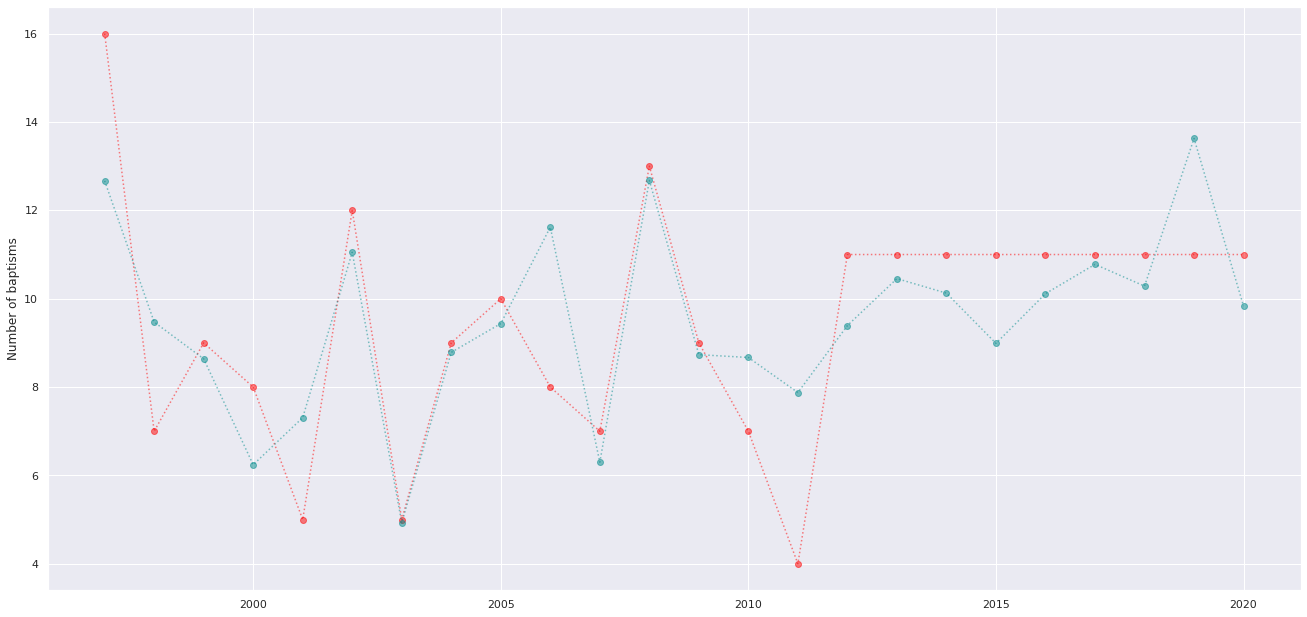

In [ ]:
df_aggregateddata['Y_pred'] = Y_pred
fig, ax = plt.subplots()
ax.plot((df_aggregateddata["rok"]), df_aggregateddata["chrzest"],marker='o',alpha=0.5, linestyle='dotted', color="red")
ax.plot((df_aggregateddata["rok"]), df_aggregateddata["Y_pred"],marker='o',alpha=0.5, linestyle='dotted', color="darkcyan")
ax.set_ylabel('Number of baptisms')
fig.set_size_inches(20, 10)

## **PCA**


In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("AMR")
install.packages("readr")
install.packages("readxl")
install.packages("devtools")
install.packages("ggplot2")

In [ ]:
%%R
library(AMR)
library(readr)
library(readxl)
library(devtools)
library(ggplot2)

R[write to console]: Loading required package: usethis



In [ ]:
%%R
df_PCA <- read_csv("df_bialowieza.csv")

Rows: 24 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): rok, chrzest, slub, zgon, GUS - Małżeństwa zawarte w gminie, GUS -...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
%%R
summary(df_PCA)

      rok          chrzest           slub            zgon     
 Min.   :1997   Min.   : 4.00   Min.   :1.000   Min.   :18.0  
 1st Qu.:2003   1st Qu.: 7.75   1st Qu.:2.000   1st Qu.:24.0  
 Median :2008   Median :10.50   Median :2.500   Median :26.0  
 Mean   :2008   Mean   : 9.50   Mean   :3.458   Mean   :27.5  
 3rd Qu.:2014   3rd Qu.:11.00   3rd Qu.:4.000   3rd Qu.:29.5  
 Max.   :2020   Max.   :16.00   Max.   :9.000   Max.   :45.0  
 GUS - Małżeństwa zawarte w gminie GUS - saldo migracji ogółem
 Min.   : 5.00                     Min.   :-27.000            
 1st Qu.: 9.00                     1st Qu.: -6.000            
 Median :11.00                     Median :  3.500            
 Mean   :10.79                     Mean   :  4.792            
 3rd Qu.:13.00                     3rd Qu.: 10.250            
 Max.   :18.00                     Max.   : 83.000            
 GUS - Ludność w gminie GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)
 Min.   :2130           Min.   :38116       

In [ ]:
%%R
cor(df_PCA)

                                                         rok     chrzest
rok                                                1.0000000  0.22449988
chrzest                                            0.2244999  1.00000000
slub                                              -0.4321265 -0.41637422
zgon                                              -0.4648515 -0.08128855
GUS - Małżeństwa zawarte w gminie                 -0.2247524  0.14064745
GUS - saldo migracji ogółem                        0.1456564  0.08218159
GUS - Ludność w gminie                            -0.9725013 -0.14989587
GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)  0.5971602  0.09659023
GUS - urodzenia żywe w gminie                     -0.5731061  0.14715552
GUS - zgony w gminie                              -0.3467813  0.06800070
CBOS - % Wierzący i praktykujący regularnie       -0.9306745 -0.24625279
CBOS - % Wierzący i praktykujący nieregularnie     0.8977182  0.20432575
CBOS - % Niewierzący i niepraktykujący             

In [ ]:
%%R
pc <- prcomp(df_PCA, center = TRUE, scale = FALSE)
summary(pc)

Importance of components:
                            PC1     PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     275.9265 92.4753 20.2221 7.49359 5.91409 3.27465 2.72248
Proportion of Variance   0.8935  0.1004  0.0048 0.00066 0.00041 0.00013 0.00009
Cumulative Proportion    0.8935  0.9938  0.9986 0.99928 0.99969 0.99982 0.99991
                           PC8     PC9    PC10    PC11   PC12   PC13
Standard deviation     1.99317 1.52888 0.97872 0.69220 0.4741 0.2833
Proportion of Variance 0.00005 0.00003 0.00001 0.00001 0.0000 0.0000
Cumulative Proportion  0.99995 0.99998 0.99999 1.00000 1.0000 1.0000


In [ ]:
%%R
pc

Standard deviations (1, .., p=13):
 [1] 275.9264675  92.4752533  20.2220896   7.4935915   5.9140933   3.2746487
 [7]   2.7224838   1.9931722   1.5288833   0.9787185   0.6921954   0.4740936
[13]   0.2833238

Rotation (n x k) = (13 x 13):
                                                           PC1           PC2
rok                                                0.024069313 -2.200931e-02
chrzest                                            0.001461658 -1.125873e-03
slub                                              -0.004299380 -7.025104e-03
zgon                                              -0.012222536 -9.246949e-04
GUS - Małżeństwa zawarte w gminie                 -0.003295828 -7.873499e-03
GUS - saldo migracji ogółem                        0.010765942  1.423118e-02
GUS - Ludność w gminie                            -0.904526378  4.243270e-01
GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)  0.424788262  9.047537e-01
GUS - urodzenia żywe w gminie                     -0.014011411  2.0787

In [ ]:
%%R
df.detr.pc <- prcomp(df_PCA, center = TRUE, scale = TRUE)
summary(df.detr.pc)

Importance of components:
                         PC1    PC2    PC3     PC4     PC5     PC6    PC7
Standard deviation     2.555 1.3088 1.1939 1.07696 0.88503 0.76866 0.5746
Proportion of Variance 0.502 0.1318 0.1096 0.08922 0.06025 0.04545 0.0254
Cumulative Proportion  0.502 0.6338 0.7435 0.83268 0.89293 0.93838 0.9638
                           PC8     PC9    PC10    PC11    PC12    PC13
Standard deviation     0.47604 0.34116 0.22893 0.20738 0.15588 0.09054
Proportion of Variance 0.01743 0.00895 0.00403 0.00331 0.00187 0.00063
Cumulative Proportion  0.98121 0.99016 0.99419 0.99750 0.99937 1.00000


In [ ]:
%%R
df.detr.pc

Standard deviations (1, .., p=13):
 [1] 2.55470503 1.30884612 1.19389618 1.07695985 0.88503146 0.76865711
 [7] 0.57458212 0.47603675 0.34115678 0.22893152 0.20738459 0.15588394
[13] 0.09054082

Rotation (n x k) = (13 x 13):
                                                          PC1          PC2
rok                                                0.36580938  0.044977885
chrzest                                            0.08794661  0.030222182
slub                                              -0.23377372  0.289829391
zgon                                              -0.22072949 -0.351934213
GUS - Małżeństwa zawarte w gminie                 -0.14293424  0.581549442
GUS - saldo migracji ogółem                        0.08625071 -0.456295055
GUS - Ludność w gminie                            -0.37636039 -0.057669019
GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)  0.31597810 -0.006439592
GUS - urodzenia żywe w gminie                     -0.22186960  0.268182280
GUS - zgony w gminie      

In [ ]:
%%R
df.detr.pc$sdev


 [1] 2.55470503 1.30884612 1.19389618 1.07695985 0.88503146 0.76865711
 [7] 0.57458212 0.47603675 0.34115678 0.22893152 0.20738459 0.15588394
[13] 0.09054082


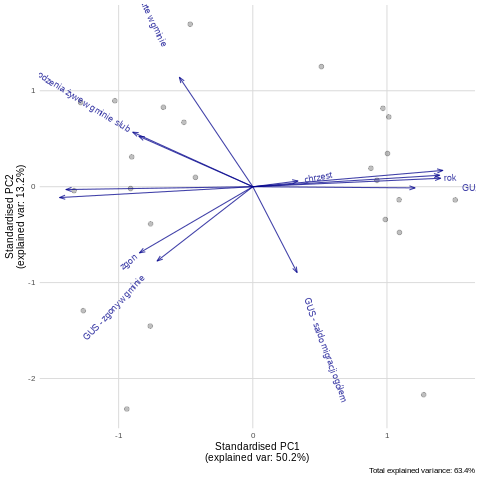

In [ ]:
%%R
ggplot_pca(df.detr.pc)

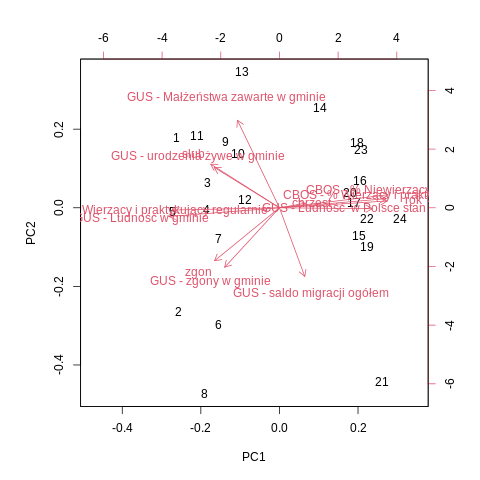

In [ ]:
%%R
biplot(df.detr.pc)

## Factor analysis - raczej do wywalenia bo nie umiem naprawić xd ewentualnie mozemy wziac cześc z tego np graf + wykres osypiska

In [ ]:
%%R 
install.packages("psych")

In [ ]:
%%R
library(psych)

In [ ]:
%%R

EFA_Model <- fa(df_PCA)
print(EFA_Model)

Factor Analysis using method =  minres
Call: fa(r = df_PCA)
Standardized loadings (pattern matrix) based upon correlation matrix
                                                    MR1    h2    u2 com
rok                                               -0.94 0.884 0.116   1
chrzest                                           -0.20 0.039 0.961   1
slub                                               0.54 0.291 0.709   1
zgon                                               0.51 0.258 0.742   1
GUS - Małżeństwa zawarte w gminie                  0.32 0.100 0.900   1
GUS - saldo migracji ogółem                       -0.19 0.035 0.965   1
GUS - Ludność w gminie                             0.98 0.955 0.045   1
GUS - Ludność  w Polsce stan w dniu 31.XII (tys.) -0.77 0.595 0.405   1
GUS - urodzenia żywe w gminie                      0.51 0.263 0.737   1
GUS - zgony w gminie                               0.42 0.179 0.821   1
CBOS - % Wierzący i praktykujący regularnie        0.94 0.876 0.124   1
CBOS - 

In [ ]:
%%R
EFA_Model$loadings


Loadings:
                                                  MR1   
rok                                               -0.940
chrzest                                           -0.198
slub                                               0.540
zgon                                               0.508
GUS - Małżeństwa zawarte w gminie                  0.316
GUS - saldo migracji ogółem                       -0.187
GUS - Ludność w gminie                             0.977
GUS - Ludność  w Polsce stan w dniu 31.XII (tys.) -0.771
GUS - urodzenia żywe w gminie                      0.513
GUS - zgony w gminie                               0.423
CBOS - % Wierzący i praktykujący regularnie        0.936
CBOS - % Wierzący i praktykujący nieregularnie    -0.934
CBOS - % Niewierzący i niepraktykujący            -0.955

                 MR1
SS loadings    6.260
Proportion Var 0.482


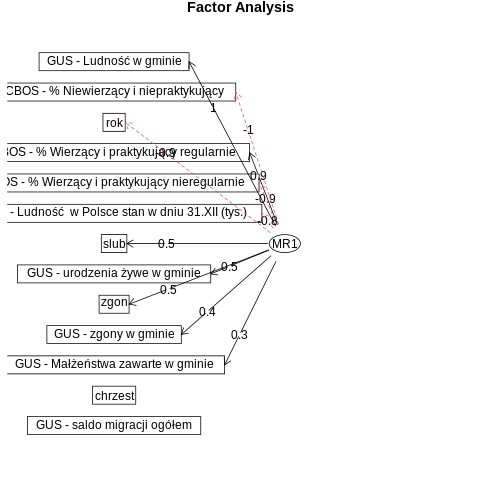

In [ ]:
%%R
fa.diagram(EFA_Model)


In [ ]:
%%R
summary(EFA_Model$scores)

      MR1         
 Min.   :-1.6840  
 1st Qu.:-0.8731  
 Median : 0.2138  
 Mean   : 0.0000  
 3rd Qu.: 0.9011  
 Max.   : 1.6100  


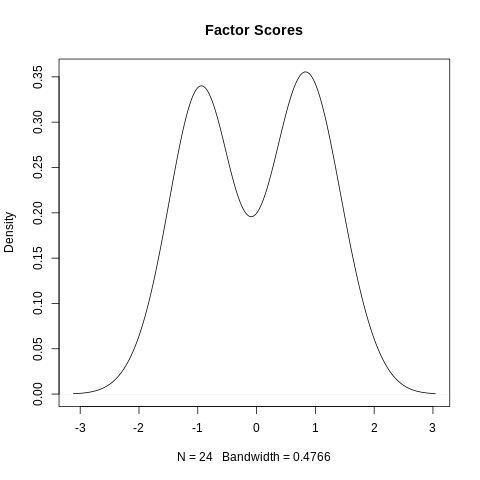

In [ ]:
%%R
plot(density(EFA_Model$scores, na.rm = TRUE), 
     main = "Factor Scores")

In [ ]:
%%R
N <- nrow(df_PCA)
indices <- seq(1, N)

indices_EFA <- sample(indices, floor(.5*N))
indices_CFA <- indices[!(indices %in% indices_EFA)]

In [ ]:
%%R

indices_EFA <- gsub(",", "",indices_EFA)
indices_CFA <- gsub(",", "",indices_CFA)
indices_EFA <- as.numeric(indices_EFA)
indices_CFA <- as.numeric(indices_CFA)

describe(indices_EFA)  
indices_EFA <- char2numeric(indices_EFA)  

describe(indices_CFA)  
indices_CFA <- char2numeric(indices_CFA)  

In [ ]:
%%R
fa_EFA <- fa[indices_EFA, ]
fa_CFA <- fa(indices_CFA, nfactors=1, use = use)

R[write to console]: Error in fa[indices_EFA, ] : object of type 'closure' is not subsettable




Error in fa[indices_EFA, ] : object of type 'closure' is not subsettable


RInterpreterError: ignored

In [ ]:
%%R
group_var <- vector("numeric", nrow(df_PCA))
group_var[indices_EFA] <- 1
group_var[indices_CFA] <- 2

fa_grouped <- cbind(df_PCA, group_var)
describeBy(fa_grouped, group = "group_var")


 Descriptive statistics by group 
group_var: 1
                                                  vars  n     mean     sd
rok                                                  1 12  2010.42   6.44
chrzest                                              2 12    10.08   1.51
slub                                                 3 12     3.00   2.09
zgon                                                 4 12    25.00   4.61
GUS - Małżeństwa zawarte w gminie                    5 12    11.08   3.42
GUS - saldo migracji ogółem                          6 12    10.42  24.79
GUS - Ludność w gminie                               7 12  2433.75 225.87
GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)    8 12 38346.25 151.53
GUS - urodzenia żywe w gminie                        9 12    15.33   5.37
GUS - zgony w gminie                                10 12    42.58   5.25
CBOS - % Wierzący i praktykujący regularnie         11 12    52.42   3.75
CBOS - % Wierzący i praktykujący nieregularnie      12 12    34.

In [ ]:
%%R
lowerCor(df_PCA, use = "pairwise.complete.obs")

                                                  rok   chrzs slub  zgon 
rok                                                1.00                  
chrzest                                            0.22  1.00            
slub                                              -0.43 -0.42  1.00      
zgon                                              -0.46 -0.08  0.29  1.00
GUS - Małżeństwa zawarte w gminie                 -0.22  0.14  0.52  0.04
GUS - saldo migracji ogółem                        0.15  0.08 -0.25 -0.06
GUS - Ludność w gminie                            -0.97 -0.15  0.47  0.50
GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)  0.60  0.10 -0.59 -0.42
GUS - urodzenia żywe w gminie                     -0.57  0.15  0.24  0.16
GUS - zgony w gminie                              -0.35  0.07  0.09  0.77
CBOS - % Wierzący i praktykujący regularnie       -0.93 -0.25  0.44  0.34
CBOS - % Wierzący i praktykujący nieregularnie     0.90  0.20 -0.41 -0.44
CBOS - % Niewierzący i niepraktykujący

In [ ]:
%%R
corr.test(df_PCA, use = "pairwise.complete.obs")$p

                                                           rok    chrzest
rok                                               0.000000e+00 1.00000000
chrzest                                           2.915876e-01 0.00000000
slub                                              3.496373e-02 0.04298208
zgon                                              2.209603e-02 0.70572939
GUS - Małżeństwa zawarte w gminie                 2.910309e-01 0.51213507
GUS - saldo migracji ogółem                       4.970677e-01 0.70263928
GUS - Ludność w gminie                            2.062961e-15 0.48448907
GUS - Ludność  w Polsce stan w dniu 31.XII (tys.) 2.063809e-03 0.65344240
GUS - urodzenia żywe w gminie                     3.418411e-03 0.49260141
GUS - zgony w gminie                              9.688230e-02 0.75221827
CBOS - % Wierzący i praktykujący regularnie       4.434696e-11 0.24606625
CBOS - % Wierzący i praktykujący nieregularnie    2.733533e-09 0.33821057
CBOS - % Niewierzący i niepraktykujący

In [ ]:
%%R
corr.test(df_PCA, use = "pairwise.complete.obs")$ci

                           lower           r        upper            p
rok-chrzs          -0.1967115159  0.22449988  0.575754792 2.915876e-01
rok-slub           -0.7114963091 -0.43212650 -0.034795247 3.496373e-02
rok-zgon           -0.7311443658 -0.46485154 -0.075638540 2.209603e-02
rok-G-Mzwg         -0.5759325358 -0.22475239  0.196455869 2.910309e-01
rok-G-smo          -0.2738297922  0.14565642  0.518582607 4.970677e-01
rok-G-Lwg          -0.9882168002 -0.97250133 -0.936495342 2.062961e-15
rok-G-LwPswd3(      0.2552517447  0.59716023  0.806320421 2.063809e-03
rok-G-użwg         -0.7931379217 -0.57310605 -0.220742629 3.418411e-03
rok-G-zwg          -0.6581141263 -0.34678128  0.065823504 9.688230e-02
rok-C-%Wipr        -0.9699295557 -0.93067450 -0.844226682 4.434696e-11
rok-C-%Wipn         0.7749644076  0.89771817  0.955201501 2.733533e-09
rok-C-%Nin          0.8291733507  0.92362921  0.966805017 1.243844e-10
chrzs-slub         -0.7018803101 -0.41637422 -0.015597291 4.298208e-02
chrzs-

In [ ]:
%%R
alpha(df_PCA)

R[write to console]: Number of categories should be increased  in order to count frequencies. 



Some items ( rok chrzest GUS - saldo migracji ogółem GUS - Ludność  w Polsce stan w dniu 31.XII (tys.) CBOS - % Wierzący i praktykujący nieregularnie CBOS - % Niewierzący i niepraktykujący ) were negatively correlated with the total scale and 
probably should be reversed.  
To do this, run the function again with the 'check.keys=TRUE' option
Reliability analysis   
Call: alpha(x = df_PCA)

  raw_alpha std.alpha G6(smc) average_r   S/N  ase mean sd median_r
      -1.7     -0.94    0.64    -0.039 -0.48 0.69 3310 14   -0.025

 lower alpha upper     95% confidence boundaries
-3.03 -1.68 -0.33 

 Reliability if an item is dropped:
                                                  raw_alpha std.alpha G6(smc)
rok                                                  -1.507     -0.49    0.68
chrzest                                              -1.680     -1.37    0.57
slub                                                 -1.701     -0.75    0.64
zgon                                                 -

In [ ]:
%%R
bfi_EFA <- bfi[indices_EFA, ]
bfi_CFA <- bfi[indices_CFA, ]

In [ ]:
%%R
bfi_EFA_cor <- cor(bfi_EFA, use = "pairwise.complete.obs")
eigenvals <- eigen(bfi_EFA_cor)
#eigenvals$values

R[write to console]: Error in eigen(bfi_EFA_cor) : infinite or missing values in 'x'

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In cor(bfi_EFA, use = "pairwise.complete.obs") :
R[write to console]: 
 
R[write to console]:  the standard deviation is zero




Error in eigen(bfi_EFA_cor) : infinite or missing values in 'x'


RInterpreterError: ignored

In [ ]:
%%R
bfi_EFA_cor

In [ ]:
%%R
scree(bfi_EFA, factors = FALSE)

R[write to console]: Error in eigen(rx) : infinite or missing values in 'x'

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In cor(rx, use = "pairwise") :
R[write to console]:  the standard deviation is zero




Error in eigen(rx) : infinite or missing values in 'x'


RInterpreterError: ignored

## K Means

In [ ]:

kmeans = KMeans(init = "k-means++", n_clusters=2).fit(df_aggregateddata)
labels1 = kmeans.labels_

kmeans = KMeans(init = "k-means++", n_clusters=3).fit(df_aggregateddata)
labels2 = kmeans.labels_

kmeans = KMeans(init = "k-means++", n_clusters=4).fit(df_aggregateddata)
labels3 = kmeans.labels_

kmeans = KMeans(init = "k-means++", n_clusters=5).fit(df_aggregateddata)
labels4 = kmeans.labels_

kmeans = KMeans(init = "k-means++", n_clusters=6).fit(df_aggregateddata)
labels5 = kmeans.labels_

kmeans = KMeans(init = "k-means++", n_clusters=7).fit(df_aggregateddata)
labels6 = kmeans.labels_

kmeans = KMeans(init = "k-means++", n_clusters=8).fit(df_aggregateddata)
labels7 = kmeans.labels_

kmeans = KMeans(init = "k-means++", n_clusters=9).fit(df_aggregateddata)
labels8 = kmeans.labels_

kmeans = KMeans(init = "k-means++", n_clusters=10).fit(df_aggregateddata)
labels9 = kmeans.labels_

kmeans = KMeans(init = "k-means++", n_clusters=11).fit(df_aggregateddata)
labels10 = kmeans.labels_

kmeans = KMeans(init = "k-means++", n_clusters=12).fit(df_aggregateddata)
labels11 = kmeans.labels_

In [ ]:
s1 = silhouette_score(df_aggregateddata, labels1)
s2 = silhouette_score(df_aggregateddata, labels2)
s3 = silhouette_score(df_aggregateddata, labels3)
s4 = silhouette_score(df_aggregateddata, labels4)
s5 = silhouette_score(df_aggregateddata, labels5)
s6 = silhouette_score(df_aggregateddata, labels6)
s7 = silhouette_score(df_aggregateddata, labels7)
s8 = silhouette_score(df_aggregateddata, labels8)
s9 = silhouette_score(df_aggregateddata, labels9)
s10 = silhouette_score(df_aggregateddata, labels10)
s11 = silhouette_score(df_aggregateddata, labels11)
print(s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11)
s = (s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11)
n_clusters = (2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)


0.7320238786080315 0.6248523063465744 0.6364541250760428 0.5246916891143018 0.4948329290737344 0.44953861381281895 0.4456188392961831 0.4198288930717591 0.3769970925889468 0.3546742030371897 0.34322164606784855


Text(0.5, 1.0, 'Visualization of profile results for individual cluster numbers')

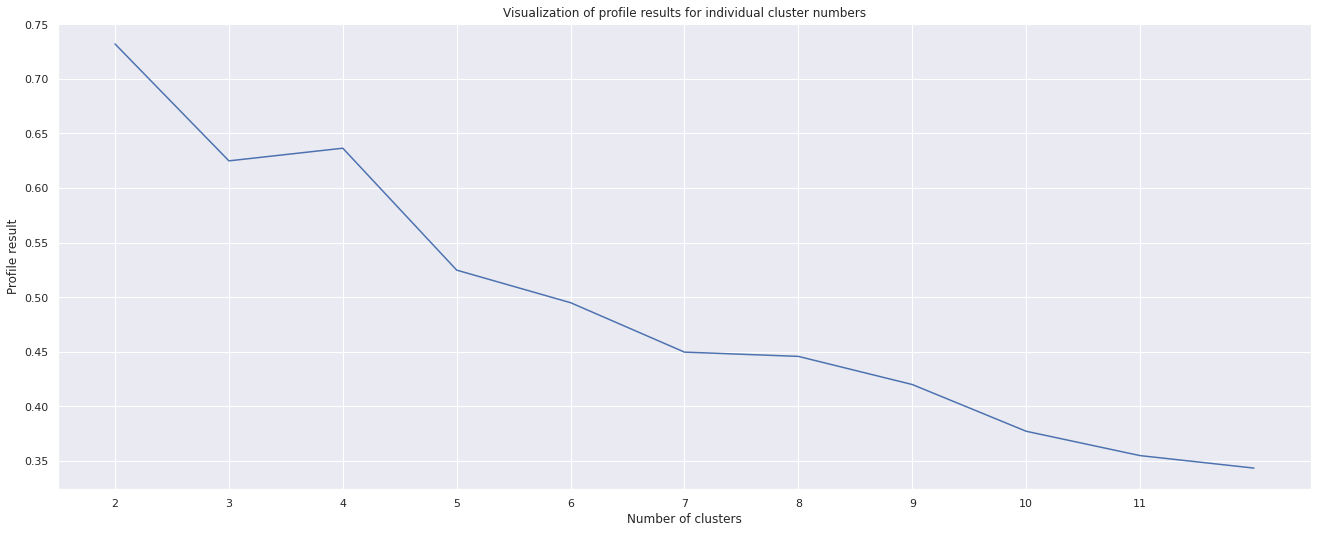

In [ ]:
plt.figure(figsize=(20,8))
g = sns.lineplot(x = n_clusters, y = s)
g.set_xticks(ticks = (2,3,4,5,6,7,8,9,10,11))
g.set(xlabel = "Number of clusters", ylabel = "Profile result");
plt.title('Visualization of profile results for individual cluster numbers')

In [ ]:
df_aggregateddata['Clusters'] = labels1
df_aggregateddata

,rok,chrzest,slub,zgon,GUS - Małżeństwa zawarte w gminie,GUS - saldo migracji ogółem,GUS - Ludność w gminie,GUS - Ludność w Polsce stan w dniu 31.XII (tys.),GUS - urodzenia żywe w gminie,GUS - zgony w gminie,CBOS - % Wierzący i praktykujący regularnie,CBOS - % Wierzący i praktykujący nieregularnie,CBOS - % Niewierzący i niepraktykujący,Y_pred,Clusters
119,1997,16.0,4.0,29.0,14.0,-9.0,2938.0,38290.0,39.0,50.0,56.0,32.0,3.0,12.667830,0
120,1998,7.0,4.0,39.0,9.0,5.0,2919.0,38277.0,20.0,55.0,57.0,32.0,3.0,9.471910,0
121,1999,9.0,4.0,23.0,12.0,10.0,2787.0,38263.0,21.0,43.0,58.0,32.0,3.0,8.639066,0
122,2000,8.0,4.0,26.0,10.0,5.0,2697.0,38254.0,23.0,45.0,58.0,32.0,3.0,6.242025,0
123,2001,5.0,7.0,45.0,13.0,-14.0,2747.0,38242.0,25.0,52.0,55.0,33.0,3.0,7.308412,0
124,2002,12.0,1.0,38.0,10.0,4.0,2714.0,38219.0,11.0,53.0,56.0,32.0,3.0,11.049443,0
125,2003,5.0,8.0,31.0,9.0,12.0,2687.0,38191.0,6.0,41.0,55.0,32.0,3.0,4.929259,0
126,2004,9.0,2.0,37.0,6.0,22.0,2671.0,38174.0,18.0,60.0,56.0,31.0,3.0,8.785427,0
127,2005,10.0,4.0,22.0,11.0,-3.0,2707.0,38157.0,18.0,34.0,58.0,32.0,3.0,9.437296,0
128,2006,8.0,3.0,19.0,12.0,3.0,2664.0,38125.0,20.0,41.0,56.0,32.0,4.0,11.619133,0


#***appendix***

## **SNN**
Spiking neural network was tested to predict orthodox church records, but was deemed unsuccessful due to the small amount of additional supporting data.

In [ ]:
X_SNN = df_aggregateddata.iloc[:, df_aggregateddata.columns != "chrzest"]
Y_SNN = df_aggregateddata["chrzest"].values.reshape(-1,1)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
 X_SNN, Y_SNN, test_size=0.33, random_state=42)

In [ ]:
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.10, random_state=1)

In [ ]:
clf = MLPRegressor(solver='adam', learning_rate='adaptive', alpha=1e-5, activation='relu', hidden_layer_sizes=(5,5,5), random_state=2, max_iter=500, batch_size=62)

In [ ]:
clf.fit(X_train, Y_train.flatten())

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:612: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  "Got `batch_size` less than 1 or larger than "
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPRegressor(alpha=1e-05, batch_size=62, hidden_layer_sizes=(5, 5, 5),
             learning_rate='adaptive', max_iter=500, random_state=2)

In [ ]:
MSE = mean_squared_error(clf.predict(X_test), Y_test.flatten())
RMSE = np.sqrt(MSE)
RMSE

9.169759147212234

In [ ]:
mean_absolute_percentage_error(clf.predict(X_test), Y_test.flatten())

47.22751636954143

In [ ]:
R_kw = r2_score(Y_test.flatten(), clf.predict(X_test))
R_kw

-9.729530359573538

In [ ]:
clf.predict(X_test)

array([ 0.14071043,  7.4806476 ,  6.59099973,  0.14071043,  0.14071043,
       10.56890874,  0.14071043])

In [ ]:
print(f'Predicted value of the observation 2 : {clf.predict(X_test)[2]}')
print(f'Real value of observation 2 : {Y_test[2]}')

Predicted value of the observation 2 : 6.5909997288624895
Real value of observation 2 : [7.]


In [ ]:
print(f'Predicted value of the observation 5 : {clf.predict(X_test)[5]}')
print(f'Real value of observation 5 : {Y_test[5]}')

Predicted value of the observation 5 : 10.568908738384293
Real value of observation 5 : [11.]


In [ ]:
print(f'Predicted value of the observation 3 : {clf.predict(X_test)[3]}')
print(f'Real value of observation 3 : {Y_test[3]}')

Predicted value of the observation 3 : 0.1407104275051567
Real value of observation 3 : [10.]
